<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 256kB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 952kB 38.2MB/s 
     |████████████████████████████████| 37.6MB 75kB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [2]:
# Download bdataset
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/bdataset_stereo.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [3]:
!git pull
!python dataset.py
!python model.py

Already up to date.
dataset ok
model ok


In [4]:
import os
import re
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [{"imageL": "data/left.png", "imageR": "data/right.png", "output": "data/output.exr"}]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.01
BETAS = [0.9, 0.999]
EPS = 0.00000001
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
DAMPENING = 0.1

MILESTONES = [10,20,30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [5]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
            M.MyIAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

detect_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [6]:
model = Model()
model.apply(init_weights)
# solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
#                           lr=LEARNING_RATE, betas=BETAS, 
#                           eps=EPS, weight_decay=WEIGHT_DECAY)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=LEARNING_RATE, momentum=MOMENTUM,
                         dampening = DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [7]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:0.1532)
======DEPTH=======
MSE=0.2599	RMSE=0.3838	MAE=0.2794	ABS_REL=1.7086
DELTA1.02=0.2206	DELTA1.05=0.3772	DELTA1.10=0.5673
DELTA1.25=0.8140	DELTA1.25^2=0.8766	DELTA1.25^3=0.9053



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:0.1087)
======DEPTH=======
MSE=0.0601	RMSE=0.2421	MAE=0.1328	ABS_REL=1.0400
DELTA1.02=0.2150	DELTA1.05=0.4604	DELTA1.10=0.7056
DELTA1.25=0.8719	DELTA1.25^2=0.9203	DELTA1.25^3=0.9396



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:0.1758)
======DEPTH=======
MSE=0.0451	RMSE=0.2102	MAE=0.1139	ABS_REL=0.9106
DELTA1.02=0.2262	DELTA1.05=0.4922	DELTA1.10=0.7709
DELTA1.25=0.8997	DELTA1.25^2=0.9420	DELTA1.25^3=0.9610



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:0.1333)
======DEPTH=======
MSE=0.0441	RMSE=0.2073	MAE=0.1148	ABS_REL=0.8500
DELTA1.02=0.2254	DELTA1.05=0.4611	DELTA1.10=0.7295
DELTA1.25=0.9065	DELTA1.25^2=0.9444	DELTA1.25^3=0.9615



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:0.2223)
======DEPTH=======
MSE=0.0393	RMSE=0.1938	MAE=0.1057	ABS_REL=1.0401
DELTA1.02=0.1922	DELTA1.05=0.4909	DELTA1.10=0.8011
DELTA1.25=0.9247	DELTA1.25^2=0.9542	DELTA1.25^3=0.9671



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:0.0762)
======DEPTH=======
MSE=0.0326	RMSE=0.1778	MAE=0.0894	ABS_REL=0.9105
DELTA1.02=0.2842	DELTA1.05=0.6543	DELTA1.10=0.8562
DELTA1.25=0.9302	DELTA1.25^2=0.9561	DELTA1.25^3=0.9668



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:0.0864)
======DEPTH=======
MSE=0.0235	RMSE=0.1497	MAE=0.0639	ABS_REL=0.8849
DELTA1.02=0.5627	DELTA1.05=0.8249	DELTA1.10=0.9010
DELTA1.25=0.9459	DELTA1.25^2=0.9675	DELTA1.25^3=0.9755



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:0.1054)
======DEPTH=======
MSE=0.0266	RMSE=0.1588	MAE=0.0781	ABS_REL=0.8515
DELTA1.02=0.3607	DELTA1.05=0.6669	DELTA1.10=0.8875
DELTA1.25=0.9397	DELTA1.25^2=0.9601	DELTA1.25^3=0.9686



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:0.0735)
======DEPTH=======
MSE=0.0270	RMSE=0.1608	MAE=0.0927	ABS_REL=0.9754
DELTA1.02=0.2105	DELTA1.05=0.4713	DELTA1.10=0.7797
DELTA1.25=0.9466	DELTA1.25^2=0.9668	DELTA1.25^3=0.9745



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:0.0639)
======DEPTH=======
MSE=0.0270	RMSE=0.1556	MAE=0.0704	ABS_REL=0.9519
DELTA1.02=0.4818	DELTA1.05=0.8082	DELTA1.10=0.8984
DELTA1.25=0.9471	DELTA1.25^2=0.9628	DELTA1.25^3=0.9713



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:0.0522)
======DEPTH=======
MSE=0.0199	RMSE=0.1382	MAE=0.0538	ABS_REL=0.8372
DELTA1.02=0.7523	DELTA1.05=0.8601	DELTA1.10=0.9043
DELTA1.25=0.9455	DELTA1.25^2=0.9654	DELTA1.25^3=0.9752



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:0.0947)
======DEPTH=======
MSE=0.0197	RMSE=0.1377	MAE=0.0497	ABS_REL=0.7844
DELTA1.02=0.7847	DELTA1.05=0.8686	DELTA1.10=0.9164
DELTA1.25=0.9506	DELTA1.25^2=0.9673	DELTA1.25^3=0.9765



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:0.0597)
======DEPTH=======
MSE=0.0175	RMSE=0.1304	MAE=0.0478	ABS_REL=0.7910
DELTA1.02=0.7838	DELTA1.05=0.8797	DELTA1.10=0.9218
DELTA1.25=0.9557	DELTA1.25^2=0.9731	DELTA1.25^3=0.9797



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:0.0509)
======DEPTH=======
MSE=0.0212	RMSE=0.1405	MAE=0.0486	ABS_REL=0.8307
DELTA1.02=0.7987	DELTA1.05=0.8828	DELTA1.10=0.9256
DELTA1.25=0.9537	DELTA1.25^2=0.9691	DELTA1.25^3=0.9761



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:0.0470)
======DEPTH=======
MSE=0.0180	RMSE=0.1316	MAE=0.0461	ABS_REL=0.7437
DELTA1.02=0.7888	DELTA1.05=0.8856	DELTA1.10=0.9281
DELTA1.25=0.9596	DELTA1.25^2=0.9737	DELTA1.25^3=0.9804



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:0.0543)
======DEPTH=======
MSE=0.0207	RMSE=0.1399	MAE=0.0497	ABS_REL=0.9608
DELTA1.02=0.8051	DELTA1.05=0.8863	DELTA1.10=0.9244
DELTA1.25=0.9524	DELTA1.25^2=0.9664	DELTA1.25^3=0.9741



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:0.1156)
======DEPTH=======
MSE=0.0152	RMSE=0.1228	MAE=0.0432	ABS_REL=0.8663
DELTA1.02=0.8053	DELTA1.05=0.8953	DELTA1.10=0.9343
DELTA1.25=0.9601	DELTA1.25^2=0.9733	DELTA1.25^3=0.9799



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:0.0736)
======DEPTH=======
MSE=0.0160	RMSE=0.1244	MAE=0.0426	ABS_REL=0.8064
DELTA1.02=0.8140	DELTA1.05=0.8948	DELTA1.10=0.9352
DELTA1.25=0.9595	DELTA1.25^2=0.9740	DELTA1.25^3=0.9802



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:0.1556)
======DEPTH=======
MSE=0.0215	RMSE=0.1407	MAE=0.0503	ABS_REL=0.8018
DELTA1.02=0.7969	DELTA1.05=0.8830	DELTA1.10=0.9208
DELTA1.25=0.9520	DELTA1.25^2=0.9701	DELTA1.25^3=0.9774



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 19, loss=(total:0.0442)
======DEPTH=======
MSE=0.0174	RMSE=0.1297	MAE=0.0466	ABS_REL=0.9070
DELTA1.02=0.8035	DELTA1.05=0.8966	DELTA1.10=0.9319
DELTA1.25=0.9572	DELTA1.25^2=0.9705	DELTA1.25^3=0.9777



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 20, loss=(total:0.0750)
======DEPTH=======
MSE=0.0154	RMSE=0.1234	MAE=0.0409	ABS_REL=0.7830
DELTA1.02=0.8343	DELTA1.05=0.9106	DELTA1.10=0.9431
DELTA1.25=0.9638	DELTA1.25^2=0.9751	DELTA1.25^3=0.9810



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 21, loss=(total:0.0637)
======DEPTH=======
MSE=0.0157	RMSE=0.1238	MAE=0.0427	ABS_REL=0.9549
DELTA1.02=0.8237	DELTA1.05=0.9030	DELTA1.10=0.9368
DELTA1.25=0.9613	DELTA1.25^2=0.9734	DELTA1.25^3=0.9797



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 22, loss=(total:0.0677)
======DEPTH=======
MSE=0.0178	RMSE=0.1300	MAE=0.0456	ABS_REL=0.8916
DELTA1.02=0.8139	DELTA1.05=0.8950	DELTA1.10=0.9259
DELTA1.25=0.9564	DELTA1.25^2=0.9695	DELTA1.25^3=0.9761



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 23, loss=(total:0.0570)
======DEPTH=======
MSE=0.0159	RMSE=0.1250	MAE=0.0416	ABS_REL=0.9231
DELTA1.02=0.8297	DELTA1.05=0.9038	DELTA1.10=0.9375
DELTA1.25=0.9592	DELTA1.25^2=0.9728	DELTA1.25^3=0.9792



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 24, loss=(total:0.0613)
======DEPTH=======
MSE=0.0168	RMSE=0.1285	MAE=0.0435	ABS_REL=0.8777
DELTA1.02=0.8302	DELTA1.05=0.9028	DELTA1.10=0.9366
DELTA1.25=0.9590	DELTA1.25^2=0.9740	DELTA1.25^3=0.9800



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 25, loss=(total:0.0767)
======DEPTH=======
MSE=0.0186	RMSE=0.1306	MAE=0.0439	ABS_REL=0.8778
DELTA1.02=0.8352	DELTA1.05=0.9076	DELTA1.10=0.9389
DELTA1.25=0.9614	DELTA1.25^2=0.9734	DELTA1.25^3=0.9795



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 26, loss=(total:0.0563)
======DEPTH=======
MSE=0.0174	RMSE=0.1295	MAE=0.0431	ABS_REL=0.9071
DELTA1.02=0.8397	DELTA1.05=0.9129	DELTA1.10=0.9424
DELTA1.25=0.9620	DELTA1.25^2=0.9730	DELTA1.25^3=0.9790



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 27, loss=(total:0.0761)
======DEPTH=======
MSE=0.0159	RMSE=0.1229	MAE=0.0410	ABS_REL=0.8017
DELTA1.02=0.8246	DELTA1.05=0.9085	DELTA1.10=0.9420
DELTA1.25=0.9613	DELTA1.25^2=0.9724	DELTA1.25^3=0.9786



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 28, loss=(total:0.0453)
======DEPTH=======
MSE=0.0154	RMSE=0.1225	MAE=0.0407	ABS_REL=1.0998
DELTA1.02=0.8382	DELTA1.05=0.9121	DELTA1.10=0.9431
DELTA1.25=0.9624	DELTA1.25^2=0.9733	DELTA1.25^3=0.9793



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 29, loss=(total:0.0812)
======DEPTH=======
MSE=0.0159	RMSE=0.1219	MAE=0.0407	ABS_REL=0.7330
DELTA1.02=0.8412	DELTA1.05=0.9101	DELTA1.10=0.9400
DELTA1.25=0.9593	DELTA1.25^2=0.9724	DELTA1.25^3=0.9787



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 30, loss=(total:0.0623)
======DEPTH=======
MSE=0.0148	RMSE=0.1192	MAE=0.0384	ABS_REL=0.7248
DELTA1.02=0.8470	DELTA1.05=0.9153	DELTA1.10=0.9452
DELTA1.25=0.9642	DELTA1.25^2=0.9751	DELTA1.25^3=0.9810



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 31, loss=(total:0.0509)
======DEPTH=======
MSE=0.0147	RMSE=0.1204	MAE=0.0395	ABS_REL=0.8295
DELTA1.02=0.8357	DELTA1.05=0.9126	DELTA1.10=0.9431
DELTA1.25=0.9617	DELTA1.25^2=0.9739	DELTA1.25^3=0.9803



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 32, loss=(total:0.0625)
======DEPTH=======
MSE=0.0150	RMSE=0.1213	MAE=0.0401	ABS_REL=0.8574
DELTA1.02=0.8390	DELTA1.05=0.9090	DELTA1.10=0.9428
DELTA1.25=0.9625	DELTA1.25^2=0.9739	DELTA1.25^3=0.9801



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 33, loss=(total:0.0597)
======DEPTH=======
MSE=0.0149	RMSE=0.1211	MAE=0.0408	ABS_REL=0.9513
DELTA1.02=0.8321	DELTA1.05=0.9060	DELTA1.10=0.9378
DELTA1.25=0.9592	DELTA1.25^2=0.9708	DELTA1.25^3=0.9775



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 34, loss=(total:0.0477)
======DEPTH=======
MSE=0.0161	RMSE=0.1248	MAE=0.0418	ABS_REL=0.8283
DELTA1.02=0.8319	DELTA1.05=0.9093	DELTA1.10=0.9401
DELTA1.25=0.9606	DELTA1.25^2=0.9747	DELTA1.25^3=0.9808



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 35, loss=(total:0.0590)
======DEPTH=======
MSE=0.0156	RMSE=0.1216	MAE=0.0400	ABS_REL=0.8418
DELTA1.02=0.8470	DELTA1.05=0.9130	DELTA1.10=0.9425
DELTA1.25=0.9623	DELTA1.25^2=0.9744	DELTA1.25^3=0.9806



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 36, loss=(total:0.0596)
======DEPTH=======
MSE=0.0167	RMSE=0.1269	MAE=0.0419	ABS_REL=0.8926
DELTA1.02=0.8336	DELTA1.05=0.9128	DELTA1.10=0.9432
DELTA1.25=0.9611	DELTA1.25^2=0.9724	DELTA1.25^3=0.9785



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 37, loss=(total:0.0548)
======DEPTH=======
MSE=0.0186	RMSE=0.1321	MAE=0.0446	ABS_REL=0.9050
DELTA1.02=0.8450	DELTA1.05=0.9083	DELTA1.10=0.9378
DELTA1.25=0.9589	DELTA1.25^2=0.9709	DELTA1.25^3=0.9773



  0%|          | 0/27 [00:00<?, ?it/s]

eval_avg_error
Epoch: 38, loss=(total:0.0450)
======DEPTH=======
MSE=0.0168	RMSE=0.1271	MAE=0.0424	ABS_REL=0.7632
DELTA1.02=0.8216	DELTA1.05=0.8998	DELTA1.10=0.9370
DELTA1.25=0.9574	DELTA1.25^2=0.9734	DELTA1.25^3=0.9798



100%|██████████| 27/27 [00:27<00:00,  1.00s/it, epoch=39, loss=(total:0.0511)]

eval_avg_error
Epoch: 39, loss=(total:0.0511)
======DEPTH=======
MSE=0.0176	RMSE=0.1260	MAE=0.0414	ABS_REL=0.8464
DELTA1.02=0.8442	DELTA1.05=0.9165	DELTA1.10=0.9454
DELTA1.25=0.9637	DELTA1.25^2=0.9746	DELTA1.25^3=0.9805



In [8]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 14/14 [00:07<00:00,  1.82it/s]

eval_avg_error
Epoch: 39, loss=(total:0.0614)
======DEPTH=======
MSE=0.0174	RMSE=0.1272	MAE=0.0397	ABS_REL=0.6965
DELTA1.02=0.8482	DELTA1.05=0.9187	DELTA1.10=0.9469
DELTA1.25=0.9644	DELTA1.25^2=0.9751	DELTA1.25^3=0.9811



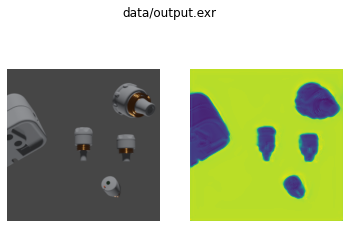

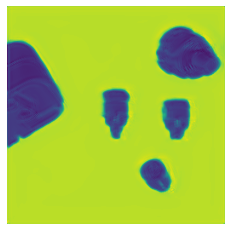

In [9]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions(predictions, [path])

In [10]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)